# Genetic algorithm to optimize investment in the stock market

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import itertools
import matplotlib.pyplot as plt

## Assign problem hyperparameters

Two types of hyperparameters exist:
 - **Fixed parameters:** defined in the project statement
 - **Test parameters:** defined by us to test different implementations of the algorithm

In [3]:
# FIXED PARAMETERS
POPULATION_SIZE = 64 # number of individuals in population
GENERATIONS = 10000   # number of generations (evaluation rounds)
MAX_RUNS = 30 # number of runs with different random seeds

# TEST PARAMETERS
CROSSOVER_PROBABILITY = 0.8 # probability of crossover operation
MUTATION_PROBABILITY = 0.2 # probability of mutation operation
TOURNAMENT_SIZE = 3 # number of individuals participating in tournament selection

## Process datasets

Filter the data relevant for the problem in question

In [4]:
def process_data(data):
    # only relevant from 01/01/2020 onwards to 31/12/2022 (3 years)
    # convert to datetime format
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data = data[data['Date'] >= '01-01-2020']
    data = data[data['Date'] <= '31-12-2022']

    # calculate the difference between consecutive values in the 'Close' column
    value_diff = data['Close'].diff()

    # create 'Gain' and 'Loss' columns based on the 'Value_Diff'
    gain = value_diff.apply(lambda x: max(0, x))
    loss = value_diff.apply(lambda x: max(0, -x))

    # calculate the rolling sum of 'Gain' and 'Loss' for a 7-day, 14-day, and 21-day periods
    average_gain_7 =  gain.rolling(window=7).mean()
    average_loss_7 =  loss.rolling(window=7).mean()
    average_gain_14 = gain.rolling(window=14).mean()
    average_loss_14 = loss.rolling(window=14).mean()
    average_gain_21 = gain.rolling(window=21).mean()
    average_loss_21 = loss.rolling(window=21).mean()

    # calculate the Relative Strength (RS)
    rs_7 = average_gain_7/average_loss_7
    rs_14 = average_gain_14/average_loss_14
    rs_21 = average_gain_21/average_loss_21

    # calculate the Relative Strength Index (RSI)
    data['RSI7'] = 100 - (100/(1+rs_7))
    data['RSI14'] = 100 - (100/(1+rs_14))
    data['RSI21'] = 100 - (100/(1+rs_21))

    # Reset the index of the DataFrame
    data.reset_index(drop=True, inplace=True)
    return data

## Initialize DEAP

In [5]:
# create the fitness function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", tuple, fitness=creator.FitnessMax)

# define the parameters
rsi_periods = [7, 14, 21]
lower_range = list(range(0, 101, 5))
upper_range = list(range(0, 101, 5))

# create the toolbox
toolbox = base.Toolbox()

toolbox.register("rsi_period", random.choice, rsi_periods)
toolbox.register("bound", random.choice, lower_range)

toolbox.register("attr_pool", tools.initCycle, tuple, [toolbox.rsi_period,
                                                       toolbox.bound,
                                                       toolbox.bound])

tools.initCycle
tools.initRepeat

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_pool, n=2)
toolbox.register("population",tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)

## Define simulation function

The simulation will be used in the **epigenesis** stage

      Date_buy   Close_buy   RSI7_buy  RSI14_buy  RSI21_buy  Date_sell  \
212 2020-11-03  130.195007  39.975434  36.899488  44.085822 2021-04-13   
339 2021-05-07  148.122498  34.333880  41.418090  53.750616 2021-06-02   
433 2021-09-21  212.460007  17.164193  33.205526  53.475592 2021-10-22   
524 2022-01-31  244.860001  52.976614  36.541659  33.948132 2022-12-30   

     Close_sell  RSI7_sell  RSI14_sell  RSI21_sell  
212  156.794998  94.055925   81.932801   74.475551  
339  167.782501  90.409430   86.963708   65.743607  
433  227.259995  91.346616   85.847718   51.654006  
524  146.139999  28.736607   31.686357   37.487811  
     Date_sell  Close_sell  RSI7_sell  RSI14_sell  RSI21_sell   Date_buy  \
34  2020-02-21   73.517502  68.447003   76.749578   65.370624 2022-01-21   
653 2022-08-05  189.889999  86.311353   72.654541   69.163917 2022-09-02   
720 2022-11-09  137.759995  55.409063   64.964058   64.537972 2022-12-30   

      Close_buy   RSI7_buy  RSI14_buy  RSI21_buy  
34   233

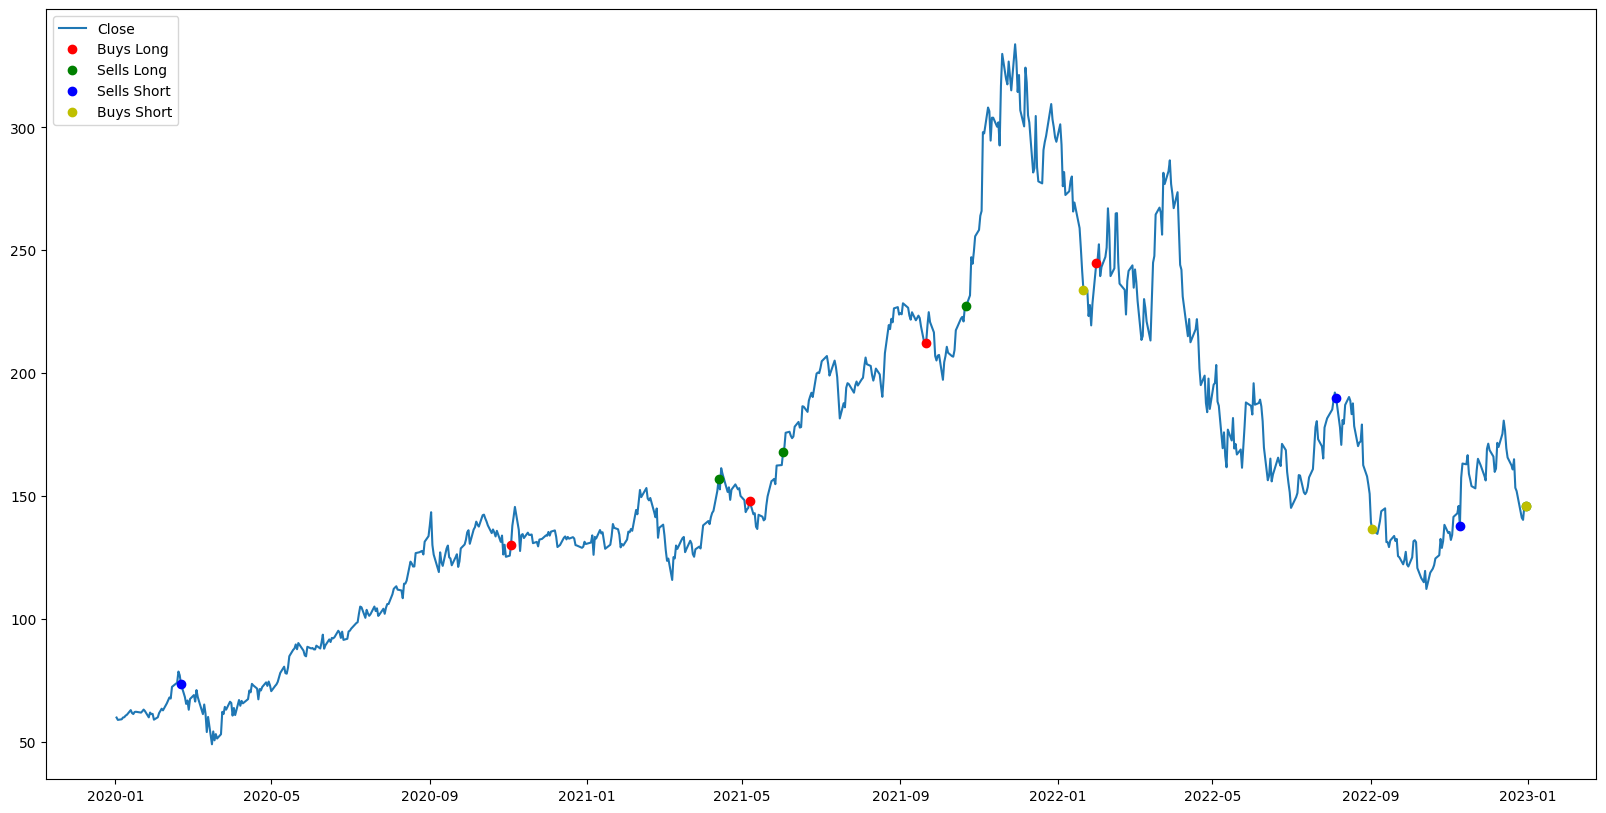

In [66]:
individual = ((21, 30, 70), (14, 30, 80))

data = pd.read_csv('data/NVDA.csv', sep=';', usecols=['Date', 'Close'])

data = process_data(data)


def simulate_trade(individual, data):
    # extract the parameters from the individual chromosome
    (rsi_period_short, lower_short, upper_short), (rsi_period_long, lower_long, upper_long) = individual
    
    rsi_period_long = "RSI" + str(rsi_period_long)
    rsi_period_short = "RSI" + str(rsi_period_short)

    # based on the parameters, choose dates to buy and sell
    long_buys = data[(data[rsi_period_long] >= lower_long) & 
                              ((data[rsi_period_long].shift(1) < lower_long) |
                               (data[rsi_period_long].shift(1) == np.nan))].copy()
    
    short_sells = data[(data[rsi_period_short] <= upper_short) &
                                ((data[rsi_period_short].shift(1) > upper_short) |
                                 (data[rsi_period_short].shift(1) == np.nan))].copy()
    
    long_sells = []
    for index, row in long_buys.iterrows():
        candidate_sells = data[(data['Date'] > row['Date']) &
                               (data[rsi_period_long] >= upper_long)]
        if (candidate_sells.empty):
            new_sell = dict(data.iloc[-1])
            new_sell['index'] = len(data) - 1
        else:
            new_sell = dict(candidate_sells.iloc[0])
            new_sell['index'] = candidate_sells.index[0]

        long_sells.append(new_sell)
        drop_rows = [i for i in long_buys.index if i > index and i < new_sell['index']]
        long_buys.drop(drop_rows, inplace=True) 

    short_buys = []
    for index, row in short_sells.iterrows():
        candidate_buys = data[(data['Date'] > row['Date']) &
                              (data[rsi_period_short] <= lower_short)]
        if (candidate_buys.empty):
            new_buy = dict(data.iloc[-1])
            new_buy['index'] = len(data) - 1
        else:
            new_buy = dict(candidate_buys.iloc[0])
            new_buy['index'] = candidate_buys.index[0]

        short_buys.append(new_buy)
        drop_rows = [i for i in short_sells.index if i > index and i < new_buy['index']]
        short_sells.drop(drop_rows, inplace=True)

    long_sells = pd.DataFrame(long_sells)
    short_buys = pd.DataFrame(short_buys)

    if not long_sells.empty:
        long_sells.drop_duplicates(subset='index', inplace=True)
        long_sells.set_index('index', inplace=True)
    else:
        long_sells = pd.DataFrame(columns=data.columns)
    if not short_buys.empty:
        short_buys.drop_duplicates(subset='index', inplace=True)
        short_buys.set_index('index', inplace=True)
    else:
        short_buys = pd.DataFrame(columns=data.columns)

    trades_long = pd.merge_asof(long_buys, long_sells, 
                                left_index=True, right_index=True, 
                                direction='forward', suffixes=('_buy', '_sell'))
    
    trades_short = pd.merge_asof(short_sells, short_buys,
                                 left_index=True, right_index=True,
                                 direction='forward', suffixes=('_sell', '_buy'))

    print(trades_long)
    print(trades_short)

    return (trades_long, trades_short)

trades_long, trades_short = simulate_trade(individual, data)

# plot evolution of RSI and points where buys and sells are possible
plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['Close'], label='Close')
plt.plot(trades_long['Date_buy'], trades_long['Close_buy'], 'ro', label='Buys Long')
plt.plot(trades_long['Date_sell'], trades_long['Close_sell'], 'go', label='Sells Long')
plt.plot(trades_short['Date_sell'], trades_short['Close_sell'], 'bo', label='Sells Short')
plt.plot(trades_short['Date_buy'], trades_short['Close_buy'], 'yo', label='Buys Short')
plt.legend(loc='upper left')
plt.show()


## Define objective function

The objective function will be used in the **selection** stage

In [ ]:
def evaluate_results(trades):
    if trades.empty:
        return 0
    # calculate the return on investment (ROI) for each trade
    trades['ROI'] = (trades['Close_sell'] - trades['Close_buy']) / trades['Close_buy'] * 100
    return average_roi

toolbox.register("evaluate", evaluate_results)

## Define selection method

The selection function will be used in the **survival** stage

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

## Define mutation method

The mutation function will be used in the **mutation** stage

## Run the algorithm

In [ ]:
def algorithm(data, RSI, price, date):
    overall = []
    seed = 30
    best_individual = None
    best_fitness = None
    for i in range(MAX_RUNS):
        random.seed(i) # set random seed for each run
        print('--Run: {0}--\n'.format(i))
        # create the initial population
        pop = toolbox.population(n=POPULATION_SIZE) # create the initial population
        print(pop)
        print('Starting evolution...')

        # fitnesses = list(map(evaluate_individual, pop)) # evaluate the individuals
        # for ind, fit in zip(pop, fitnesses):
        #     ind.fitness.values = fit
    pass

folder_path = 'data'

file_list = os.listdir(folder_path)

data_dictionary = {}
RSI_dictionary = {}
price_dictionary = {}
date_dictionary = {}

for file_name in file_list:
    if file_name.endswith('.csv'):
        # extract the base name of the file (without the extension)
        df_name = os.path.splitext(file_name)[0]
        # construct the full file path
        file_path = os.path.join(folder_path, file_name)
            # read the CSV file into a DataFrame with the base name as the variable name
        data_dictionary[df_name] = pd.read_csv(file_path, sep=';', usecols=['Date', 'Close'])
        data, rsi, price, date = process_data(data_dictionary[df_name])
        data_dictionary[df_name] = data
        RSI_dictionary[df_name] = rsi
        price_dictionary[df_name] = price
        date_dictionary[df_name] = date
for df_name in data_dictionary:
    algorithm(data_dictionary[df_name], RSI_dictionary[df_name], price_dictionary[df_name], date_dictionary[df_name])